In [ ]:
from collections import defaultdict, Counter
from functools import lru_cache
from typing import List, Iterable, Dict, Callable
from abc import abstractmethod
import pandas as pd
import scipy
import numpy as np
from scipy import sparse as sp
from tqdm import tqdm
from scipy.sparse.linalg import svds

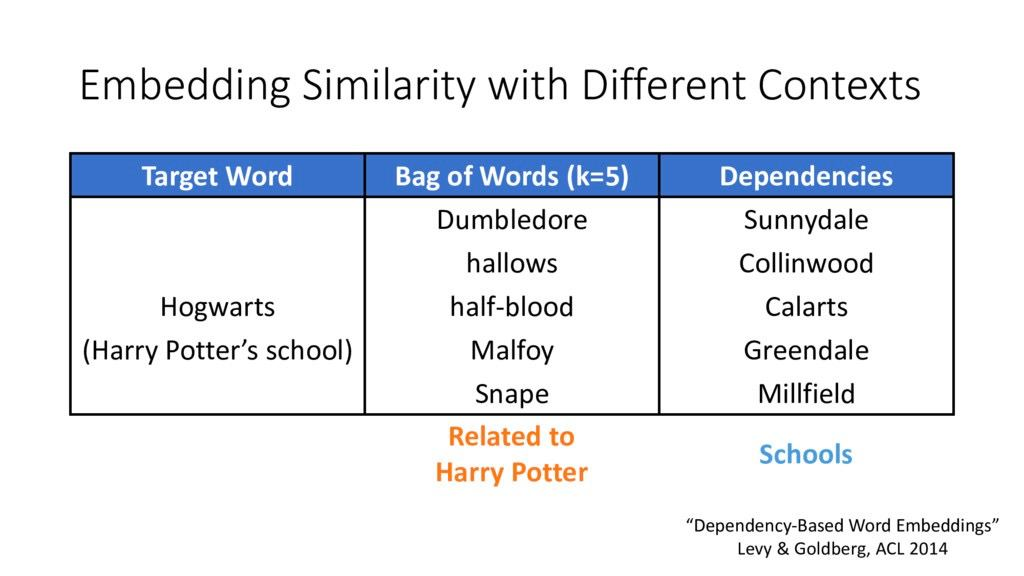

In [ ]:
data = pd.read_csv("/content/vectors/gold.csv")

In [ ]:
golden = [ans for ans in data["sim"]]
examples = [(w1, w2) for w1, w2 in zip(data["word1"], data["word2"])]
assert len(golden) == len(examples)

In [ ]:
class Sentences(object):
    """ Итератор по строкам заданных файлов, не загружающий их полностью в RAM """

    def __init__(self, filenames: Iterable[str]):
        self.filenames: Iterable = filenames

    def __iter__(self):
        for filename in self.filenames:
            for line in open(filename, "r+", encoding="utf-8"):
                yield line.strip().replace("ё", "е").split(" ")

In [ ]:
class EmbeddingModel:
    
    @abstractmethod
    def get(word: str) -> np.array:
        raise NotImplementedError

### Реализуйте PPMI + SVD подход [3 балла]

In [ ]:
class PPMIEmbeddings(EmbeddingModel):
    """
        Класс, строящий векторные представления для каждого из интересующих нас термов
        по набору предобработанных текстов, а также вычисляющий меру их сходства
        на основе косинусного расстояния, и задающий порог для него, говорящий, похожи два данных
        терма или нет (`are_similar`).
    """

    def __init__(self,
                 n_features: int = 400,
                 threshold: float = 0.2,
                 window_half_size: int = 2,
                 min_df: int = 5,
                 max_df: int = 1000000):
        """
            @param: threshold Порог для отсечения по косинусному расстоянию
            @param: window_half_size Половинка "окна", то есть макс. расстояние от центра окна
            @param: min_df Если частота терма ниже этого порога -- выбрасываем (not implemented)
            @param: max_df Если частота терма выше этого порога -- выбрасываем (not implemented)
        """
        self.n_features = n_features
        self.th, self.whs = threshold, window_half_size
        self.ppmi, self.counts, self.ppmi_dense = None, None, None
        self.min_df, self.max_df = min_df, max_df

        # список термов
        self.id2token: List[str] = []
        # словарь индексов термов
        self.token2id: Dict[str, int] = {}

    @lru_cache(maxsize=100000000)
    def _idx(self, token: str):
        """ Кэширующий метод, получающий индекс терма """

        if token not in self.token2id:
            curr_idx = len(self.id2token)
            self.token2id[token] = curr_idx
            self.id2token.append(token)
        else:
            curr_idx = self.token2id[token]
        return curr_idx

    def _reset(self):
        """ Сброс всего 'выученного' (но не гиперпараметров) """
        self.pmi, self.counts, self.token2id, self.id2token = None, None, {}, []
    
    def _coocurance_count(self, text_reader, for_exclusion):
        # счётчик, номер строки, номер столбца
        values, fromm, too = [], [], []

        # общее число -- может пригодиться для нормализации и др.
        total_counts = defaultdict(lambda: 0)

        for sentence in tqdm(text_reader(), "sentences"):

            # проходим центром по предложению
            for c in range(len(sentence)):
                #TODO

                # проходим вдоль окна
                for idx in range(max(0, c - self.whs), min(len(sentence), c + self.whs)):
                    # TODO
        
        coo = sp.coo_matrix((values, (fromm, too)))
        coo.sum_duplicates()
        return coo, total_counts
    
    def _pmi_calculation(self, coo):
        nonzero_size = len(coo.nonzero()[0])
        print(f"Sparsity: %.2f nonzero values: a total of %d." % \
              (100 * nonzero_size / coo.shape[0] / coo.shape[1], nonzero_size))
        
        values = []
    
        total_counts_sum = self.counts.sum()
        # coo *= total_counts_sum
        
        for i, j, v in tqdm(zip(coo.row, coo.col, coo.data), "computing PPMI", total=nonzero_size):
            #TODO
    
        # преобразовываем в разреженную матрицу с эффективной укладкой по строкам
        self.ppmi = sp.csr_matrix(sp.coo_matrix((values, (coo.row, coo.col))))
        self.ppmi_dense = ...
        

    def fit(self, text_reader: Callable):
        
        """
            Построение матрицы с векторными представлениями
            на основе поданных предобработанных предложений.
            Базовый выданный код -- не самый эффективный,
            для удобства проведения инкрементальных улучшений
            рекомендуется ускорить.
            YOUR CODE HERE, так сказать.
        """
        
        self._reset()
        word_counter = Counter()

        for_exclusion = []

        for key in tqdm(word_counter.keys(), "bad guys"):
            # check if the word is 'bad'
            if word_counter[key] < self.min_df or word_counter[key] > self.max_df:
                for_exclusion.append(key)

        for_exclusion = set(for_exclusion)
        print("For exclusion, terms:", len(for_exclusion))
        
        coo, total_counts = self._coocurance_count(text_reader, for_exclusion)

        # строим разреженную матрицу на основе полученных троек

        # укладываем общую встречаемость термов в массив
        self.counts = sp.csr_matrix(np.array([total_counts[i] for i in range(len(self.id2token))]))

        print(f"A total of {len(self.id2token)} terms.")
        print(f"Matrix of size {coo.shape} was built.")
        
        self._pmi_calculation(coo)
        
        return None

    def get(self, word: str) -> np.array:

        word = word.replace("ё", "е")
        
        #TODO

In [ ]:
sentences = lambda: Sentences(filenames=["/Users/Ivan.Dolgov/ivandolgov/CSC/yds/nlp_course/data/vectors/rus_araneum_maxicum-1M_lines.txt"])
whs, th, mindf = 3, 0.4, 10
embs = PPMIEmbeddings(window_half_size=whs, threshold=th, min_df=mindf)
embs.fit(sentences)

bad guys: 0it [00:00, ?it/s]


For exclusion, terms: 0


sentences: 1000000it [00:30, 33063.27it/s]


A total of 204858 terms.
Matrix of size (204858, 204858) was built.
Sparsity: 0.04 nonzero values: a total of 17542013.


computing PPMI:  32%|███▏      | 5656658/17542013 [24:37<50:43, 3905.78it/s]  

In [ ]:
from scipy.spatial import distance
class SimilarityModel:
    
    def __init__(self, 
                model: EmbeddingModel,
                threshold: float):
        self._th = threshold
        self._model = model
        self._skipped = 0
    
    def score(self, word1: np.array, word2: np.array) -> float:
        return distance.cosine(word1, word2)
    
    def are_similar(self, word1: str, word2: str) -> bool:
        try:
            wv1, wv2 = self._model.get(word1+"_NOUN"), self._model.get(word2+"_NOUN")
            return self.score(wv1, wv2) < self._th
        except KeyError:
            self._skipped += 1
            return False

In [ ]:
from sklearn.metrics import average_precision_score
def caluclate_metric(similarity_model: SimilarityModel):
    predict = [int(similarity_model.are_similar(w1, w2)) for w1, w2 in examples]
    return average_precision_score(golden, predict)

In [ ]:
# for debug (using 100k data)
assert caluclate_metric(SimilarityModel(model=embs, threshold=0.4)) >= 0.38

In [ ]:
assert caluclate_metric(SimilarityModel(model=embs, threshold=0.4)) >= 0.385
print("Slytherin gets 3 points")
# assert caluclate_accuracy(SimilarityModel(model=..., threshold=0.5)) >= 0.46
# print("Hufflepuff gets 2 points")
# assert caluclate_accuracy(SimilarityModel(model=..., threshold=0.5)) >= 0.47
# print("Ravenclaw gets 1 points")
# assert caluclate_accuracy(SimilarityModel(model=..., threshold=0.5)) >= 0.51
# print("Gryffindor gets 2 points")

### Реализуйте метод на основе predictive подхода [2 балл]

In [ ]:
class PredectiveEmbeddingModel(EmbeddingModel):
    #TODO

In [ ]:
# assert caluclate_accuracy(SimilarityModel(model=..., threshold=0.4)) >= 0.6
# print("Slytherin gets 2 points")